- Preprocessing (Apply for each frame)
    - **Projection on ground grid (reprojection)**
        - Create ground grid (define resolution dx == dy)
        - Interpolate from drone grid to ground
    - **Correct for the glint (Normalization)**
        - Fit 2D gaussian filter
        - Devide intensity by gaussian filter  
    - **Export NetCDF**


In [1]:
import os
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

In [2]:
# Processing config
dir_in = 'drone/100123' # Dir with video frames
dir_out = f'{dir_in}/projections' # Dir with projected outputs
name_out = 'frame'
band = 0 # RGB band ID
h_drone = 500,
subsampling = 3 # Every N pixel in x and y
res_reg = 2 # Final pixel size
kernel_size = 20 # Kernel size for the gaussian filter
method = 'cubic' # Interpolation method
time_step = 1 # seconds

In [3]:
def projection(x, y, h, alpha):
    """
    Reproject data from the original (drone) x, y grid to ground grid
    using camera height over ground and angle resolution of the camera.
    
    :param x: 2d array, with range coordinates in meters
    :param y: 2d array, with azimuth coordinates in meters 
    :param h: float, height of the camera (drone) over ground in meters
    :param alpha: float, angular resolution of the camera in rad.
    :returns x_proj: 2d array, projected x coordinates on ground range in meters
    :returns y_proj: 2d array, projected y coordinates on ground range in meters
    """
    x_proj = np.tan(x*alpha) * h
    y_proj = np.tan(y*alpha) * h
    return x_proj, y_proj

def process_one_frame(file_img, h_drone, band=1, subsampling=1, alpha=0.0005251, res_reg=1, kernel_size=40, interp_method='linear'):
    """
    Read, normalize, and project a frame. 
    
    NOTE: Projection of data from camera grid to regular ground range grid:
        1. Create camera grid (for original image) using angular resolution and size of the frame
        2. Create ground range (irregular) grid and project data from the camera grid (see 1)
        3. Project from the ground range grid to the regular grid
        
    NOTE: Final grid is meters with x = y = 0 in the center of the frame
        
    :param file_img: str, path to the frame
    :param h_drone: height of the camera (drone) in meters
    :param band: int, 0,1, or 2 for RGB bands. NOTE: check band ids
    :param subsampling: subsampling factor (use every n pix in both x and y)
    :param alpha: angular resolution of the camera in rad. 
    :param res_reg:
    :param kernel_size: ???
    :param interp_method: method for griddata function
    :returns x_reg: ground range x coordinates in meters
    :returns y_reg: ground range y coordinates in meters
    :returns data_corrected: reprojected data from the band
    """
    # Read image file
    rgb_img = imread(file_img)
    # image values
    data = rgb_img[:,:, band]
    # subsampling
    data = convolve2d(data,np.ones((subsampling,subsampling))/subsampling**2)
    data = data[::subsampling, ::subsampling]
    # Generate camera grid
    y_img = np.arange(-data.shape[0]/2, data.shape[0]/2)
    x_img = np.arange(-data.shape[1]/2, data.shape[1]/2)
    # Project from camera grid to ground coordinates
    x_grnd, y_grnd = projection(x_img, y_img, h=h_drone, alpha=subsampling*alpha)
    # Create a ground range x and y mesh
    x2d_grnd, y2d_grnd = np.meshgrid(x_grnd, y_grnd)
    # Interpolate to regular grid
    # Generate 1d x and y regular-grid coordinates
    x_reg = np.arange(x_grnd[0], x_grnd[-1], res_reg)
    y_reg = np.arange(y_grnd[0], y_grnd[-1], res_reg)
    # Create regular x and y mesh
    x2d_reg, y2d_reg = np.meshgrid(x_reg, y_reg)
    # Linear interpolation
    # Inter polate data from original camera grid to ground range grid using linear interpolation
    data_interp = griddata((x2d_grnd.flatten(), y2d_grnd.flatten()), data.flatten(),
                           (x2d_reg.flatten(),y2d_reg.flatten()), method=interp_method).reshape(x2d_reg.shape)
    # Correct for sun glint
    if kernel_size is not None:
        glint = gaussian_filter(data_interp, sigma=kernel_size)
        data_corrected = data_interp/glint
    else: 
        data_corrected = +data_interp
    
    return x_reg, y_reg, data_corrected

In [4]:
# input files
files_in = glob.glob(f'{dir_in}/*.png')

# output file names
files_out = []
for i in range(len(files_in)):
    file = os.path.split(files_in[i])[-1]
    num = file[4:-4].zfill(6)
    files_out.append(f'{dir_out}/{name_out}_band{band}_sub{subsampling}_res{res_reg}_{method}_kernel{kernel_size}_dt{time_step}s_{num}.nc')

# sorting
ind = np.argsort(files_out) 
files_in = list(np.array(files_in)[ind])
files_out = sorted(files_out)

# create output directory
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    
print(files_out[-1])

drone/100123/projections/frame_band0_sub3_res2_cubic_kernel20_dt1s_048999.nc


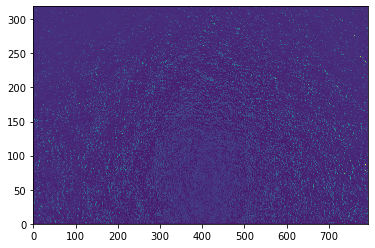

In [5]:
plot = True

for i in range(len(files_in)):
    
    print(i,len(files_in),end='\r')
    
    # Processing
    x, y, data = process_one_frame(
        files_in[i],
        h_drone=h_drone, 
        band=band,
        subsampling=subsampling, 
        res_reg=res_reg, 
        kernel_size=kernel_size,
        interp_method=method
    )
    
    if plot:
        plt.figure()
        plt.pcolormesh(data)
        plt.show()
        plot = False
    
    # Save to netcdf
    ds = nc.Dataset(files_out[i],mode='w')
    ds.createDimension('time',0)
    ds.createDimension('x',x.size)
    ds.createDimension('y',y.size)
    var = ds.createVariable('time','f4',dimensions=('time'))
    var[:] = i*time_step
    var = ds.createVariable('data','f8',dimensions=('time','y','x'))
    var[:] = data[np.newaxis,:,:]
    ds.close()

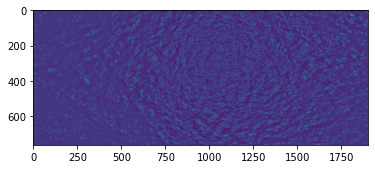

In [6]:
n = nc.Dataset('DJI_0398/projections/frame_band0_sub3_res0.5_cubic_kernel20_dt1s_003981.nc')
plt.figure()
plt.imshow(n['data'][0,:,:])

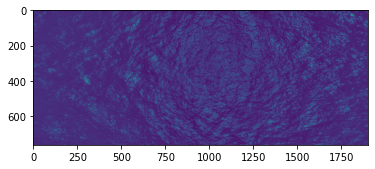

In [7]:
n = nc.Dataset('DJI_0398/projections/frame_band0_sub3_res0.5_cubic_kernel80_dt1s_003981.nc')
plt.figure()
plt.imshow(n['data'][0,:,:])
n.close()